## Семинар 15: "Обучение с подкреплением 2"

ФИО: Ира Букреева

###  FrozenLake


<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>



In [1]:
import gym
import numpy as np 
import random

#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

In [2]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

## Задание 1.
Подберите значения alpha и epsilon и найдите приближение оптимальной Q-функции для Frozen Lake.

In [3]:
class QLearn:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        oldv = self.q.get((state, action), None)

        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def chooseAction(self, state):
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.getQ(state, a) for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma*maxqnew)

In [4]:
qlearn = QLearn(actions=range(env.env.nA), gamma=1, epsilon=0.1, alpha=0.2)

In [5]:
def run_episode_qlearn_learn(env, qlearn, gamma = 1.0, render = False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        qlearn.learn(obs, action, reward, obs_new)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [6]:
def run_episode_qlearn(env, qlearn, gamma = 1.0, render = False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [7]:
def evaluate_qlearn(env, qlearn, gamma = 1.0,  n = 100):
    scores = [
            run_episode_qlearn(env, qlearn, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

In [8]:
# 1. Подберите значения alpha и epsilon и найдите приближение оптимальной Q-функции для Frozen Lake
from itertools import product

best_alpha, best_eps, best_reward = 0, 0, 0
alphas = np.arange(0,11) / 10
epsilons = np.arange(0,11) / 10

for alpha, epsilon in product(alphas, epsilons):
    qlearn = QLearn(actions = range(env.env.nA), epsilon = epsilon, alpha = alpha)
    for i in range(1000):
        run_episode_qlearn(env, qlearn)
    avg_reward = evaluate_qlearn(env, qlearn, n=1000)
    if avg_reward > best_reward:
        best_alpha, best_epsilon = alpha, epsilon
        best_reward = avg_reward

In [9]:
print ("best_alpha: {0}, best_eps: {1}, best_reward: {2}".format(best_alpha, best_eps, best_reward) )

best_alpha: 0.5, best_eps: 0, best_reward: 0.025


## Задание 2.
Обучите сеть DQN для среды http://gym.openai.com/envs/Pong-v0/ 

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html - основываясь на этом туториале

In [10]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [11]:
env = gym.make('Pong-v0')

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
class DQN(nn.Module):

    def __init__(self, outputs=3):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(nn.Conv2d(3, 16, 2, stride=4),
#                                     nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 32, 2, stride=4),
#                                     nn.BatchNorm2d(32)
                                    nn.ReLU()
                                    )
        self.linear = nn.Sequential(nn.Linear(4160, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, outputs)
                                    )

    def forward(self, x):
        bs = x.shape[0] // 210
        x = x.reshape((bs, 3, 210, 160))
        x = self.layers(x)
        x = x.view(bs, 4160)
        x = self.linear(x)
        return x

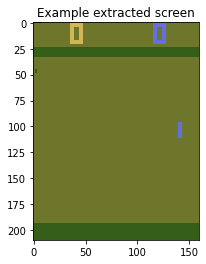

In [14]:
def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return screen


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [15]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10


policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.tensor([[policy_net(state).argmax(1)]], dtype=torch.int64)
    else:
        return torch.tensor([[random.randrange(2)]], dtype=torch.int64)

In [16]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# episode 0


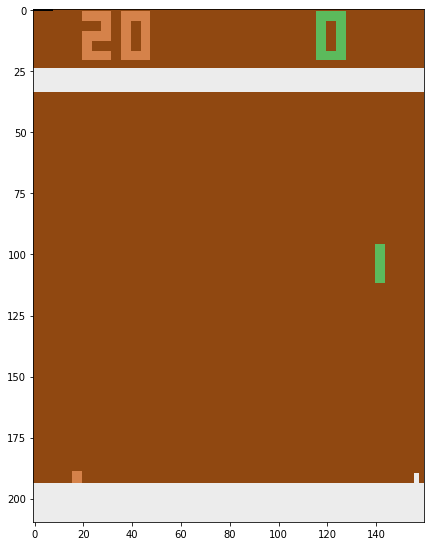

# episode 1


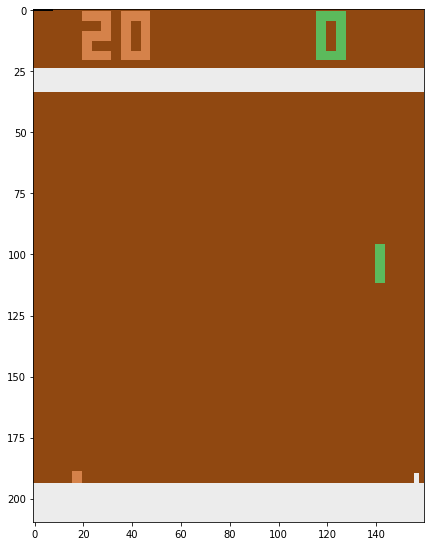

# episode 2


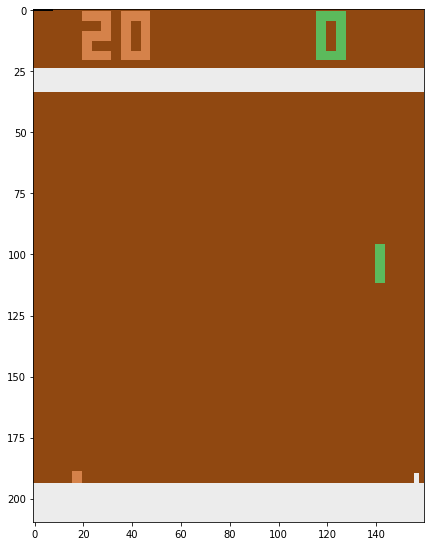

# episode 3


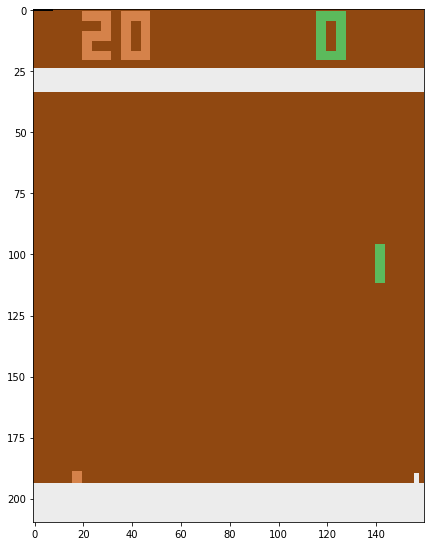

# episode 4


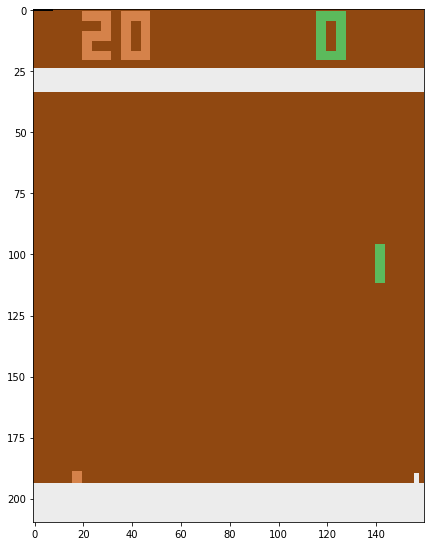

# episode 5


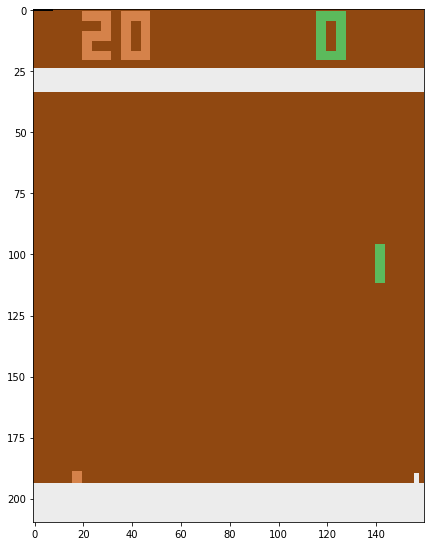

# episode 6


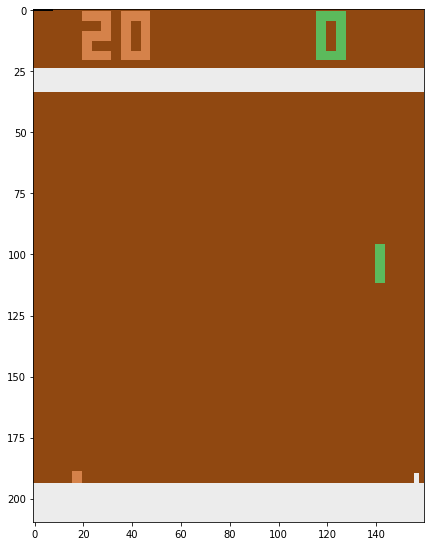

# episode 7


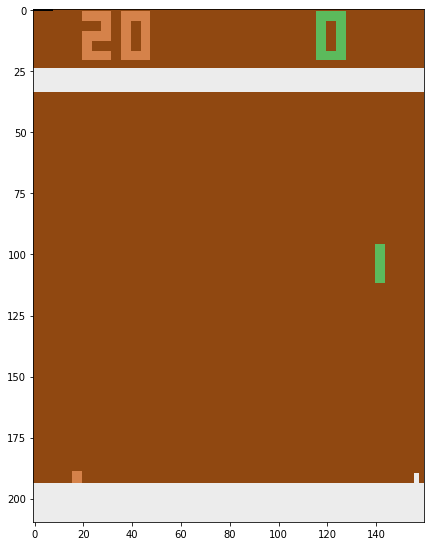

# episode 8


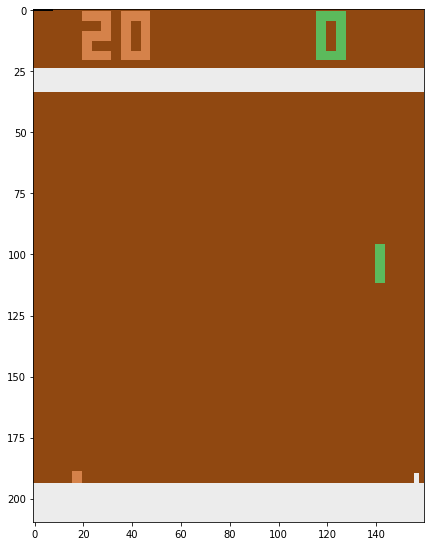

# episode 9


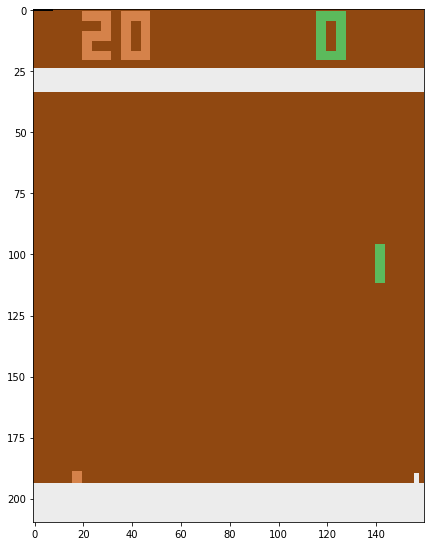

In [17]:
num_episodes = 10
for i_episode in range(num_episodes):
    
    print("# episode", i_episode)
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item()) 
        reward = torch.tensor([reward])

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        if done:
            plt.figure(figsize=(7,12))
            plt.imshow(get_screen().squeeze(0).numpy(),
                       interpolation='none')
            plt.show()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
env.close()